# How to use the RNN Disaggregator with NILMTK

This is an example on how to train and use the Recurrent Network (RNN) disaggregator on the [REDD](http://redd.csail.mit.edu/) dataset using [NILMTK](https://github.com/nilmtk/NILMTK/).

First of all, we need to train the RNNDisaggregator using the train data. For this example, both train and test data are consumption data of the microwave of the first REDD building.

In [ ]:
from nilmtk.dataset_converters import convert_redd
convert_redd('/data/REDD/low_freq', '/data/redd.h5')

In [1]:
import warnings;
warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('../../redd/data/REDD.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[1].elec

Next, we need to define the disaggregator model.

In [2]:
from rnndisaggregator_stacked import RNNDisaggregator
rnn = RNNDisaggregator()

Using TensorFlow backend.


In [3]:
train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

In [ ]:
train_elec.mains().all_meters()[0]

In [ ]:
train_elec.submeters()['fridge']

Then train the model. We need to input the train data as well as their sample period. Also, we need to pass the desired number of training epochs. Finally, save the model for later use.

In [4]:
#train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_mains = train_elec.submeters().select_top_k(k=5)
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=1, sample_period=1)
#rnn.export_model("model-redd5.h5")

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Loading data for meter ElecMeterID(instance=6, building=1, dataset='REDD')      ) ...   
Done loading data all meters for this chunk.
Epoch 1/1
1003066/1003066 [==============================] - 693s 691us/step - loss: 1.9486e-04
Epoch 1/1
1003066/1003066 [==============================] - 522s 520us/step - loss: 1.1683e-04


Now that the model is trained, we can use it to disaggregate energy data. Let's test it on the rest of the data from building 1.

First we use the model to predict the microwave consumption. The results are saved automatically in a .h5 datastore.

In [5]:
test = DataSet('../../redd/data/REDD.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
#test_mains = test_elec.mains().all_meters()[0]
test_mains = test_elec.submeters().select_top_k(k=5)

disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=20, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=6, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
New sensible chunk: 12

Let's plot the results and compare them to the ground truth signal.

**Note:** Calling plot this way, downsamples the signal to reduce computing time. To plot the entire signal call
```
predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()
```

In [6]:
result = DataSet(disag_filename)

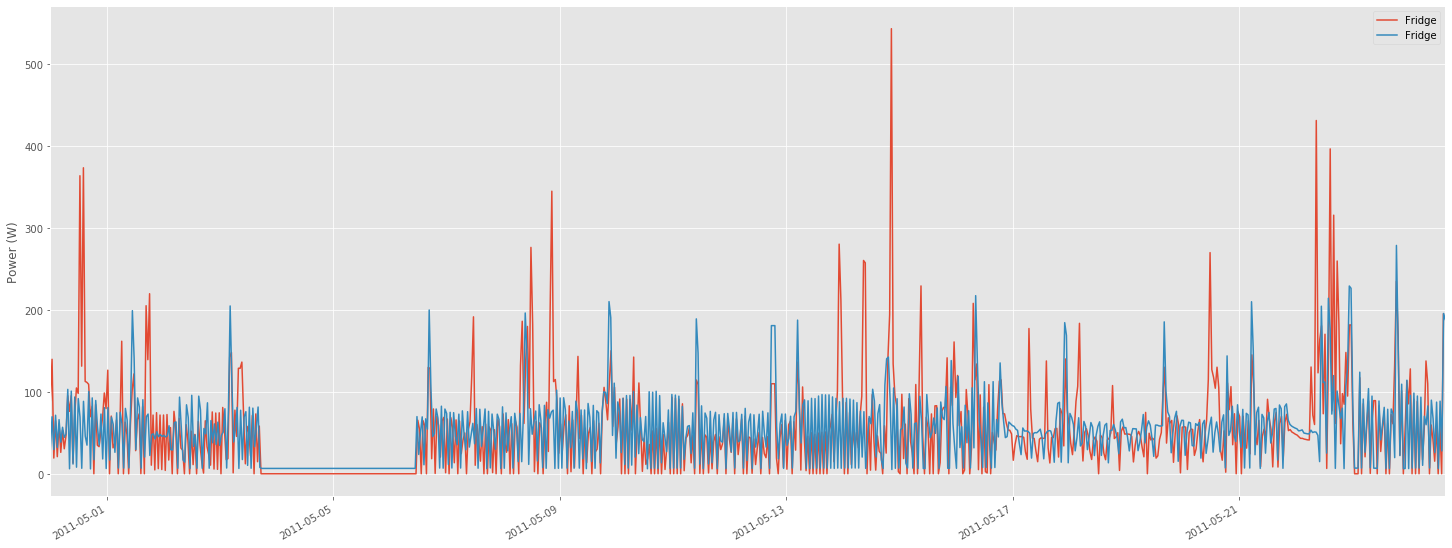

In [9]:
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig1 = plt.figure(figsize=(25,10))
predicted.plot()
ground_truth.plot()
plt.show()

Finally let's see the metric results.

In [11]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))
print("============ Root Mean squared error(in Watts): {}".format(metrics.root_mean_squared_error(predicted, ground_truth)))

============ Recall: 0.38011099941690346
============ Precision: 0.9469787849407589
============ Accuracy: 0.4820356569270332
============ F1 Score: 0.5424758092681169
============ Relative error in total energy: 0.750591203925105
============ Mean absolute error(in Watts): 51.387404762465096


AttributeError: module 'metrics' has no attribute 'root_mean_squared_error'